# mRS distribution derivation, step-by-step

Because Anna has become muddled once again

In [93]:
import numpy as np
import matplotlib.pyplot as plt

![](./images/excess_deaths_mt.png)

In [94]:
mrs_dists = dict()
mrs_dists['pre_stroke_lvo'] = np.array([0.4179, 0.1430, 0.1184, 0.1642, 0.1138, 0.0427, 0.0000])
mrs_dists['no_treatment_lvo'] = np.array([0.0500, 0.0790, 0.1360, 0.1640, 0.2470, 0.1350, 0.1890])

In [95]:
mrs_dists_cumsum = dict()
for key, val in zip(mrs_dists.keys(), mrs_dists.values()):
    mrs_dists_cumsum[key] = np.cumsum(mrs_dists[key])

In [109]:
mrs_dists_cumsum

{'pre_stroke_lvo': array([0.4179, 0.5609, 0.6793, 0.8435, 0.9573, 1.    , 1.    ]),
 'no_treatment_lvo': array([0.05 , 0.129, 0.265, 0.429, 0.676, 0.811, 1.   ])}

In [96]:
def convert_prob_to_logodds(p):
    return np.log(p / (1.0 - p))

In [97]:
# Probabilities in pre-stroke and no-treatment dists:
# P(mRS < 6)
p_pre = mrs_dists_cumsum['pre_stroke_lvo'][5]
p_not = mrs_dists_cumsum['no_treatment_lvo'][5]

# Target probability at average MT treatment time:
p_death_mt = 97.0 / 633.0
p_target = 1.0 - p_death_mt
l_target = convert_prob_to_logodds(p_target)

# Times in hours:
t0 = 0.0
tne = 8.0
# Average MT treatment time:
t_target = (285.0 / 60.0)

In [98]:
p_pre, p_not, p_target

(1.0, 0.811, 0.8467614533965244)

In [99]:
def calculate_logodds_with_excess_deaths(p_pre, p_not, ed):
    # Weight pre-stroke probability by excess deaths:
    p_pre_deaths = p_pre * (1.0 - ed)
    # Weight no-treatment probability by excess deaths:
    p_tne = p_not * (1.0 - ed)
    # Calculate new time-zero-treatment probability by
    # combining the new pre-stroke and no-treatment dists:
    p_t0 = 0.75 * p_pre_deaths + 0.25 * p_tne

    # Convert time-zero and time-of-no-effect probs to logodds:
    l_t0 = convert_prob_to_logodds(p_t0)
    l_tne = convert_prob_to_logodds(p_tne)
    return l_t0, l_tne

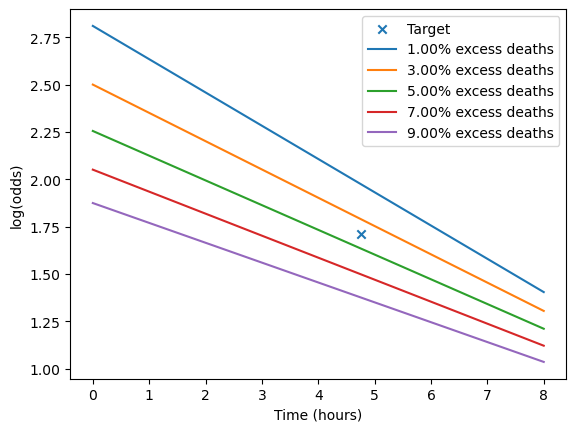

In [106]:
plt.scatter(t_target, l_target, label='Target', marker='x')
for ed in np.arange(0.01, 0.10, 0.02):
    # Find endpoints of the straight line for this excess deaths value:
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)
    # Plot the straight line fit:
    plt.plot(
        [t0, tne],
        [l_t0, l_tne],
        label=f'{ed:.2%} excess deaths'
    )
plt.legend()
plt.ylabel('log(odds)')
plt.xlabel('Time (hours)')
plt.show()

## Optimize the value of "excess deaths"

In [101]:
def calculate_logodds_t_target(ed, p_pre, p_not, tne, t0):
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)

    slope = (l_tne - l_t0) / (tne - t0)
    y_intercept = l_t0

    l_t_target = slope * t_target + y_intercept
    return l_t_target

In [102]:
def calculate_difference_logodds_t_target(ed, args):
    l_t_target = calculate_logodds_t_target(ed, *args)
    return np.abs(l_target - l_t_target)

In [103]:
from scipy.optimize import minimize

In [107]:
results = minimize(
    calculate_difference_logodds_t_target,
    0.3,
    args = [p_pre, p_not, tne, t0],
    method='Nelder-Mead'
)

# Save the optimized excess deaths value:
ed_opt = results.x[0]

# View full results:
results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.5973663145384407e-05
             x: [ 4.008e-02]
           nit: 17
          nfev: 34
 final_simplex: (array([[ 4.008e-02],
                       [ 4.006e-02]]), array([ 2.597e-05,  8.750e-05]))

Check that this value is sensible by plotting its straight line fit:

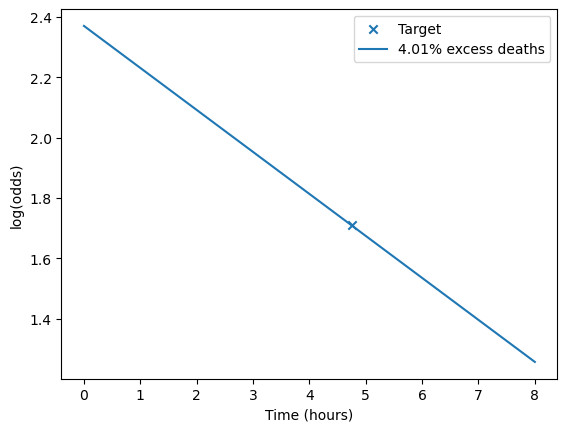

In [108]:
plt.scatter(t_target, l_target, label='Target', marker='x')

l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed_opt)
plt.plot(
    [t0, tne],
    [l_t0, l_tne],
    label=f'{ed_opt:.2%} excess deaths'
)

# l_t_target_opt = calculate_logodds_t_target(ed_opt)
# plt.scatter(t_target, l_t_target_opt, marker='x', color='k')
plt.ylabel('log(odds)')
plt.xlabel('Time (hours)')
plt.legend()
plt.show()